In [1]:
import os.path as osp
import torch
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GNNExplainer, GCNConv
from torch_geometric.utils import k_hop_subgraph, from_networkx
import pickle
import networkx as nx
from math import floor
from tqdm import tqdm
import seaborn as sns
from scipy.sparse import coo_matrix,csr_matrix

import sys
sys.path.append("..")

from model.BayesExplainer import BayesExplainer
from model.samplers.NFSampler import NFSampler

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

G = nx.read_gpickle('data/syn3_G.pickle')
with open('data/syn3_lab.pickle', 'rb') as f:
    labels = pickle.load(f)

x = torch.tensor([x[1]['feat'] for x in G.nodes(data=True)])
edge_index = torch.tensor([x for x in G.edges])
edge_index_flipped = edge_index[:, [1, 0]]
edge_index = torch.cat((edge_index, edge_index_flipped))
y = torch.tensor(labels, dtype=torch.long)
data = Data(x=x, edge_index=edge_index.T, y=y)

class Net(torch.nn.Module):
    def __init__(self, x=64):
        super(Net, self).__init__()
        self.conv1 = GCNConv(10, x)
        self.conv2 = GCNConv(x, x)
        self.conv3 = GCNConv(x, x)
        self.fc = torch.nn.Linear(x, max(y).tolist()+1)

    def forward(self, x, edge_index):
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        return self.fc(x)
    
# Load everything onto the gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
x, edge_index = data.x, data.edge_index

model = Net(x=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

best_loss = 100
pbar = tqdm(range(10000))
for epoch in pbar:
    # Training step
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.cross_entropy(log_logits, data.y)
    loss.backward()
    optimizer.step()

    # Testing step
    model.eval()
    best_loss = loss if loss < best_loss else best_loss
    pbar.set_description("Acc -> %.4f" % torch.mean((torch.argmax(log_logits, dim=1) == data.y).float()).item())

/var/folders/ss/d51rr5hd6t35mk152_9djsym0000gn/T/ipykernel_47639/3167418107.py:24: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')
Acc -> 0.9403: 100%|██████████| 10000/10000 [01:54<00:00, 87.46it/s]


Explain node 549: 100%|██████████| 1000/1000 [00:02<00:00, 432.36it/s]


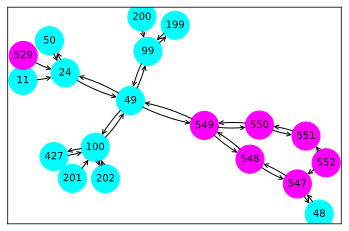

In [2]:
explainer = GNNExplainer(model, epochs=1000)
node_idx = 549
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/shalinpatel/virtualenv/GCN-Integration/lib/python3.9/site-packages/pyro/util.py:293: UserWarning: Found vars in model but not guide: {'y_sample', 'm'}
  warnings.warn(
Loss -> 11.8825: 100%|██████████| 2000/2000 [03:39<00:00,  9.13it/s]


<AxesSubplot:>

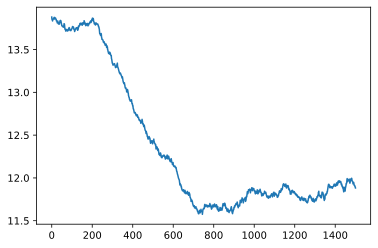

In [9]:
k = 3
splines = 8
sampler = NFSampler("nf_sampler", len(G.edges), splines, True, 10, 1.5, device)
explainer = BayesExplainer(model, sampler, node_idx, k, x, edge_index)
avgs = explainer.train(epochs=2000, lr=0.25, window=500, log=True)
sns.lineplot(x = range(len(avgs)), y = avgs)

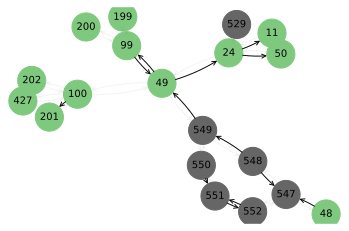

In [10]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, data.y, k)
plt.show()

/Users/shalinpatel/virtualenv/GCN-Integration/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

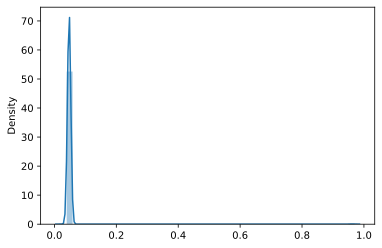

In [11]:
sns.distplot(explainer.sampler.flow_dist.rsample(torch.Size([10000,])).sigmoid()[:, 7].detach().numpy())